# Folktables: Data-Point Reconstruction Attack & Utility Analysis

This notebook simulates a data-point reconstruction attack against a federated k-means algorithm on the **Folktables** dataset. This dataset is different from the Gaussian mixture as its data is sparse and binary (which we convert to float).

The simulation is broken down into these steps:
1.  **Setup:** Import libraries and define all helper functions from the `folktables_datapoint.py` script.
2.  **Baseline Utility:** Train one full non-private model and one full private model (on all data) to measure their baseline k-means cost and accuracy. This demonstrates the **privacy-utility tradeoff**.
3.  **Load Attack Data:** Load the Folktables federated dataset (partitioned by US State) that the attacker will use to select targets.
4.  **Run Attack:** For `NUM_ATTACKS` iterations:
    a. Pick a random client (a US State) and a random data point from their dataset.
    b. **Train a model *without* that single point** (once for private, once for non-private). This creates the `centers_baseline`.
    c. Simulate the client's update *with* the point (`noisy_update_in`).
    d. Simulate the client's update *without* the point (`noisy_update_out`).
    e. The reconstructed point is `(noisy_update_in - noisy_update_out)`.
    f. Compare the reconstruction to the true point using **L2 Error** and **Cosine Similarity**.
5.  **Final Report:** Display the utility metrics and the attack metrics (with histograms) side-by-side.
6.  **Cleanup:** Remove all generated config and results files.

In [1]:
# --- 1. Setup & Imports ---

In [2]:
import subprocess
import os
import numpy as np
import yaml
import random
from sklearn.metrics import pairwise_distances
import sys
import math
import pickle 
import argparse # For Namespace object
from pathlib import Path
import matplotlib.pyplot as plt

# --- Add project root to path to ensure imports work ---
# This notebook assumes it is in 'reconstruction_attacks/'
# To run from 'fed-dp-kmeans-main/', change PROJECT_ROOT to "."
PROJECT_ROOT = ".." 
if PROJECT_ROOT not in sys.path:
    try:
        notebook_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        notebook_dir = os.path.abspath('')
    
    project_root_path = os.path.abspath(os.path.join(notebook_dir, PROJECT_ROOT))
    if project_root_path not in sys.path:
        print(f"Adding {project_root_path} to system path.")
        sys.path.insert(0, project_root_path)

# --- Import from project files ---
try:
    from data import make_data, set_data_args, add_data_arguments
    from utils import kmeans_cost, add_utils_arguments, set_seed, make_results_path
    from utils.argument_parsing import maybe_inject_arguments_from_config
    from pfl.data.sampling import get_user_sampler
    from pfl.data.federated_dataset import FederatedDataset
    from pfl.stats import MappedVectorStatistics
    from privacy.utils import get_mechanism
    from algorithms import add_algorithms_arguments
except ImportError as e:
    print(f"Error: {e}")
    print("Please ensure this notebook is in the 'reconstruction_attacks' directory,")
    print("or change the PROJECT_ROOT variable to point to the 'fed-dp-kmeans-main' directory.")

Adding /home/ojmaha/Desktop/IITB/sem7/CS6007/Fed-DP-KMeans-and-MIA-Attack/fed-dp-kmeans-main to system path.


In [ ]:
# --- Main Configuration ---

# Number of attack iterations (target data points). Max 51 (one per state).
NUM_ATTACKS = 10

# Global random seed for reproducibility.
SEED = 10

# Base config file to use for Folktables DP settings.
BASE_CONFIG_PATH = '../configs/folktables.yaml'

# --- IMPORTANT --- 
# This MUST match the filter_label in your base config, or you can override it here.
# 2 = Not-for-profit, 5 = Federal gov't, 6 = Self-employed
FILTER_LABEL = 2

In [4]:
# --- Helper Functions (From your folktables_datapoint.py script) ---

In [5]:
# Define the list of state abbreviations used as client IDs in folktables
STATE_LIST = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


# --- create configs (Adapted for Folktables) ---
def create_recon_configs_folktables_datapoint(base_config_path='../configs/folktables.yaml', filter_label=2):
    """Creates non-private and private config files for data-point level attack on Folktables."""
    try:
        with open(base_config_path, 'r') as f: base_config = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"Warning: Base config file '{base_config_path}' not found. Using defaults.")
        base_config = {'dataset': 'folktables', 'filter_label': 2, 'K': 10, 'samples_per_mixture_server': 10,'num_uniform_server': 1000, 'initialization_algorithm': 'FederatedClusterInitExact','clustering_algorithm': 'FederatedLloyds', 'minimum_server_point_weight': 5, 'fedlloyds_num_iterations': 1,'datapoint_privacy': True, 'outer_product_epsilon': 1, 'weighting_epsilon': 1,'center_init_gaussian_epsilon': 1, 'center_init_epsilon_split': 0.5, 'fedlloyds_epsilon': 1,'fedlloyds_epsilon_split': 0.5, 'outer_product_clipping_bound': 2.65, 'weighting_clipping_bound': 1,'center_init_clipping_bound': 2.65, 'center_init_laplace_clipping_bound': 1, 'fedlloyds_clipping_bound': 2.65,'fedlloyds_laplace_clipping_bound': 1, 'overall_target_delta': 1e-6, 'fedlloyds_delta': 1e-6,'send_sums_and_counts': True}
    except Exception as e:
        print(f"Error loading base config '{base_config_path}': {e}. Using defaults.")
        base_config = {'dataset': 'folktables', 'filter_label': 2, 'K': 10, 'samples_per_mixture_server': 10,'num_uniform_server': 1000, 'initialization_algorithm': 'FederatedClusterInitExact','clustering_algorithm': 'FederatedLloyds', 'minimum_server_point_weight': 5, 'fedlloyds_num_iterations': 1,'datapoint_privacy': True, 'outer_product_epsilon': 1, 'weighting_epsilon': 1,'center_init_gaussian_epsilon': 1, 'center_init_epsilon_split': 0.5, 'fedlloyds_epsilon': 1,'fedlloyds_epsilon_split': 0.5, 'outer_product_clipping_bound': 2.65, 'weighting_clipping_bound': 1,'center_init_clipping_bound': 2.65, 'center_init_laplace_clipping_bound': 1, 'fedlloyds_clipping_bound': 2.65,'fedlloyds_laplace_clipping_bound': 1, 'overall_target_delta': 1e-6, 'fedlloyds_delta': 1e-6,'send_sums_and_counts': True}

    # --- Override filter_label from function arg --- 
    base_config['filter_label'] = filter_label

    # Ensure necessary keys are present
    base_config.setdefault('fedlloyds_num_iterations', 1); base_config.setdefault('num_train_clients', 51)
    base_config.setdefault('fedlloyds_cohort_size', base_config.get('num_train_clients', 51))
    base_config.setdefault('send_sums_and_counts', True); 
    base_config.setdefault('fedlloyds_epsilon', 1); base_config.setdefault('fedlloyds_epsilon_split', 0.5)
    default_delta = base_config.get('overall_target_delta', 1e-6)
    base_config.setdefault('overall_target_delta', default_delta); base_config.setdefault('fedlloyds_delta', default_delta)
    base_config.setdefault('fedlloyds_clipping_bound', 2.65); base_config.setdefault('fedlloyds_laplace_clipping_bound', 1)

    os.makedirs("configs", exist_ok=True)

    # Config 1: Non-Private (DP flags off, datapoint_privacy=False)
    config_non_private = base_config.copy()
    config_non_private.update({
        'datapoint_privacy': False,
        'outer_product_privacy': False, 
        'point_weighting_privacy': False,
        'center_init_privacy': False, 
        'fedlloyds_privacy': False,
        'fedlloyds_num_iterations': 1
    })
    config_non_private_fname = 'configs/folktables_datapoint_non_private.yaml'
    with open(config_non_private_fname, 'w') as f: yaml.dump(config_non_private, f, sort_keys=False)

    # Config 2: Private (DP flags on, datapoint_privacy=True)
    config_private = base_config.copy()
    config_private.update({
        'datapoint_privacy': True,
        'outer_product_privacy': True, 
        'point_weighting_privacy': True,
        'center_init_privacy': True, 
        'fedlloyds_privacy': True,
        'fedlloyds_num_iterations': 1
    })
    config_private.setdefault('fedlloyds_clipping_bound', 2.65); config_private.setdefault('fedlloyds_laplace_clipping_bound', 1)
    config_private.setdefault('fedlloyds_delta', config_private.get('overall_target_delta', 1e-6))
    config_private_fname = 'configs/folktables_datapoint_private.yaml'
    with open(config_private_fname, 'w') as f: yaml.dump(config_private, f, sort_keys=False)

    print("Folktables single-point reconstruction attack config files created.")
    return config_non_private_fname, config_private_fname

# --- get_target_data (Adapted for Folktables type) ---
def get_target_data(target_client_id_str, all_train_clients):
    """Fetches the raw data (X matrix) for the target client (state)."""
    user_sampler = get_user_sampler('minimize_reuse', [target_client_id_str])
    target_dataset = FederatedDataset(all_train_clients.make_dataset_fn, user_sampler)
    (user_dataset, _) = next(target_dataset.get_cohort(1))
    data = user_dataset.raw_data[0]
    if hasattr(data, 'numpy'): data = data.numpy()
    if data.dtype == bool: data = data.astype(np.float32) # Ensure float
    return data

# --- run_training_get_centers (for attack) ---
def run_training_get_centers(config_file, exclude_client_id_str=None, exclude_datapoint_str=None, seed=None):
    cmd = ['python', '../run.py', '--args_config', config_file]
    if exclude_client_id_str: cmd.extend(['--exclude_client_id_str', exclude_client_id_str])
    if exclude_datapoint_str: cmd.extend(['--exclude_datapoint', exclude_datapoint_str])
    if seed is not None: cmd.extend(['--seed', str(seed)])
    print(f"\nRunning command: {' '.join(cmd)}")
    try: subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e: print(f"Error running training: {e}"); return None
    except FileNotFoundError: print("Error: 'python' command not found."); return None
    center_file = 'final_centers.npy'
    if not os.path.exists(center_file): print(f"Error: Center file '{center_file}' not found."); return None
    return center_file

# --- run_main_training_for_utility (For baseline utility) ---
def run_main_training_for_utility(config_file, seed=None):
    """Runs run.py *without* exclusions to generate baseline utility metrics."""
    cmd = ['python', '../run.py', '--args_config', config_file]
    if seed is not None: cmd.extend(['--seed', str(seed)])
    print(f"\nRunning command for baseline utility: {' '.join(cmd)}")
    try: subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e: print(f"Error running baseline utility training: {e}"); return False
    except FileNotFoundError: print("Error: 'python' command not found."); return False
    return True

# --- get_baseline_utility ---
def get_baseline_utility(config_file, seed=None):
    """
    Runs main training once and fetches the cost/accuracy from its summary file.
    """
    success = run_main_training_for_utility(config_file, seed=seed)
    if not success:
        return np.nan, np.nan

    try:
        config_namespace = load_config_as_namespace(config_file) 
    except Exception as e:
        print(f"Error loading config {config_file} to get results path: {e}")
        return np.nan, np.nan

    model_cost, model_accuracy = np.nan, np.nan
    try:
        privacy_type = 'data_point_level' if config_namespace.datapoint_privacy else 'client_level'
        results_path = make_results_path(privacy_type, config_namespace.dataset)
        summary_file = os.path.join(results_path, 'summary_results.pkl')
        
        if os.path.exists(summary_file):
            with open(summary_file, 'rb') as f:
                results_dict = pickle.load(f)
            final_results_key = 'Clustering' if 'Clustering' in results_dict else 'Initialization'
            if final_results_key in results_dict:
                model_cost = results_dict[final_results_key].get('Train client cost', np.nan)
                model_accuracy = results_dict[final_results_key].get('Train client accuracy', np.nan)
        else:
            print(f"  > Warning: Could not find summary file for utility: {summary_file}")
    except Exception as e:
        print(f"  > Error loading model metrics: {e}")
        
    return model_cost, model_accuracy

# --- load_config_as_namespace (Adapted for Folktables defaults) ---
def load_config_as_namespace(config_file):
    with open(config_file, 'r') as f: config_dict = yaml.safe_load(f)
    # Add ALL missing defaults
    config_dict.setdefault('num_train_clients', 51); config_dict.setdefault('send_sums_and_counts', True)
    config_dict.setdefault('center_init_send_sums_and_counts', False); 
    config_dict.setdefault('datapoint_privacy', False) # Default to false
    default_delta = config_dict.get('overall_target_delta', 1e-6); config_dict.setdefault('overall_target_delta', default_delta)
    config_dict.setdefault('fedlloyds_num_iterations', 1); config_dict.setdefault('fedlloyds_cohort_size', config_dict.get('num_train_clients', 51))
    config_dict.setdefault('fedlloyds_epsilon', 1.0); config_dict.setdefault('fedlloyds_epsilon_split', 0.5)
    config_dict.setdefault('fedlloyds_delta', default_delta)
    config_dict.setdefault('fedlloyds_clipping_bound', 2.65); config_dict.setdefault('fedlloyds_laplace_clipping_bound', 1) # Folktables DP defaults
    config_dict.setdefault('outer_product_epsilon', 1.0); config_dict.setdefault('outer_product_delta', default_delta)
    config_dict.setdefault('outer_product_clipping_bound', 2.65)
    config_dict.setdefault('weighting_epsilon', 1.0); config_dict.setdefault('weighting_clipping_bound', 1)
    config_dict.setdefault('center_init_gaussian_epsilon', 1.0); config_dict.setdefault('center_init_delta', default_delta)
    config_dict.setdefault('center_init_epsilon_split', 0.5); config_dict.setdefault('center_init_clipping_bound', 2.65)
    config_dict.setdefault('center_init_laplace_clipping_bound', 1)
    config_dict.setdefault('filter_label', 2) # Ensure filter label exists
    config_dict.setdefault('dataset', 'folktables') # Ensure dataset is set
    return argparse.Namespace(**config_dict)

# --- simulate_client_contribution (Identical logic, handles float conversion) ---
def simulate_client_contribution(client_data, global_centers, config_namespace, seed=None):
    K = global_centers.shape[0]; dim = global_centers.shape[1]
    # Ensure float32 for calculations
    if client_data.dtype != np.float32: client_data = client_data.astype(np.float32)
    if global_centers.dtype != np.float32: global_centers = global_centers.astype(np.float32)

    if client_data.shape[0] == 0:
        raw_sums = np.zeros((K, dim), dtype=np.float32); raw_counts = np.zeros(K, dtype=np.float32)
    else:
        dist_matrix = pairwise_distances(client_data, global_centers); assignments = np.argmin(dist_matrix, axis=1)
        raw_sums = np.zeros((K, dim), dtype=np.float32); raw_counts = np.zeros(K, dtype=np.float32)
        for k in range(K):
            mask = (assignments == k)
            if np.any(mask): raw_sums[k] = np.sum(client_data[mask], axis=0); raw_counts[k] = np.sum(mask)
    raw_stats_dict = {}
    if config_namespace.send_sums_and_counts: raw_stats_dict['sum_points_per_component'] = raw_sums; raw_stats_dict['num_points_per_component'] = raw_counts
    else: raise NotImplementedError("Only supports 'send_sums_and_counts=True'")
    raw_stats = MappedVectorStatistics(raw_stats_dict)
    mechanism_name = 'fedlloyds' if config_namespace.fedlloyds_privacy else 'no_privacy'
    try:
        if not hasattr(config_namespace, 'fedlloyds_delta'): config_namespace.fedlloyds_delta = config_namespace.overall_target_delta
        mechanism_wrapper = get_mechanism(config_namespace, mechanism_name); underlying_mechanism = mechanism_wrapper.underlying_mechanism
    except Exception as e: print(f"Error getting mechanism '{mechanism_name}': {e}"); raise
    try: sim_seed_clip = seed + 1 if seed is not None else None; clipped_stats, _ = underlying_mechanism.constrain_sensitivity(raw_stats, seed=sim_seed_clip)
    except Exception as e: print(f"Error during constrain_sensitivity: {e}"); clipped_stats = raw_stats
    try: sim_seed_noise = seed + 2 if seed is not None else None; noisy_stats, _ = underlying_mechanism.add_noise(clipped_stats, cohort_size=1, seed=sim_seed_noise)
    except Exception as e: print(f"Error during add_noise: {e}"); noisy_stats = clipped_stats
    final_noisy_sums = np.zeros_like(raw_sums); final_noisy_counts = np.zeros_like(raw_counts)
    if config_namespace.send_sums_and_counts:
        if 'sum_points_per_component' in noisy_stats: final_noisy_sums = noisy_stats['sum_points_per_component']
        else: print("Warning: 'sum_points_per_component' missing.")
        if 'num_points_per_component' in noisy_stats: final_noisy_counts = noisy_stats['num_points_per_component']
        else: print("Warning: 'num_points_per_component' missing.")
    else: raise NotImplementedError("Only supports 'send_sums_and_counts=True'")
    final_noisy_counts = np.maximum(0, final_noisy_counts); return final_noisy_sums, final_noisy_counts

# --- run_reconstruction_once_folktables_single_point (MODIFIED) ---
def run_reconstruction_once_folktables_single_point(config_file, target_client_id_str, target_sample_idx,
                                         target_datapoint_vector, full_client_data, seed=None):
    """Returns (L2 Error, Cosine Similarity)"""
    try:
        config_namespace = load_config_as_namespace(config_file)
        if not config_namespace.send_sums_and_counts: 
            print(f"Error: Config {config_file} needs send_sums_and_counts=True.")
            return np.nan, np.nan
    except Exception as e: 
        print(f"Error loading config {config_file}: {e}")
        return np.nan, np.nan

    print("Running training WITHOUT target POINT to get baseline global centers...")
    exclude_str = f"{target_client_id_str}:{target_sample_idx}"
    train_seed = seed + 50 if seed is not None else None
    centers_file = run_training_get_centers(config_file, exclude_datapoint_str=exclude_str, seed=train_seed)
    if centers_file is None: 
        print("Failed to get baseline global centers.")
        return np.nan, np.nan
    try: 
        global_centers_baseline = np.load(centers_file).astype(np.float32) # Ensure float32
    except Exception as e: 
        print(f"Error loading centers {centers_file}: {e}"); error = np.nan
    finally:
        if os.path.exists(centers_file): os.remove(centers_file)
        if 'error' in locals(): return error, np.nan

    print(f"Simulating contribution WITH target point {target_client_id_str}:{target_sample_idx}...")
    sim_seed_in = seed + 101 if seed is not None else None
    try: 
        noisy_sums_in, noisy_counts_in = simulate_client_contribution(full_client_data, global_centers_baseline, config_namespace, seed=sim_seed_in)
    except Exception as e: 
        print(f"Error simulating IN contribution: {e}")
        return np.nan, np.nan

    print(f"Simulating contribution WITHOUT target point {target_client_id_str}:{target_sample_idx}...")
    client_data_out = np.delete(full_client_data, target_sample_idx, axis=0)
    sim_seed_out = seed + 102 if seed is not None else None
    try: 
        noisy_sums_out, noisy_counts_out = simulate_client_contribution(client_data_out, global_centers_baseline, config_namespace, seed=sim_seed_out)
    except Exception as e: 
        print(f"Error simulating OUT contribution: {e}")
        return np.nan, np.nan

    diff_sums = noisy_sums_in - noisy_sums_out; diff_counts = noisy_counts_in - noisy_counts_out

    if diff_counts.size == 0: 
        print("Error: diff_counts empty.")
        reconstructed_point = np.full(target_datapoint_vector.shape[1], np.nan)
    else:
        tie_breaker = np.random.randn(*diff_counts.shape) * 1e-9
        probable_cluster_idx = np.argmax(diff_counts + tie_breaker)
        reconstructed_point = diff_sums[probable_cluster_idx]

    error, cosine_sim = np.nan, np.nan
    if np.isnan(reconstructed_point).any():
        print(f"Target {target_client_id_str}:{target_sample_idx}: Reconstruction failed (NaN).")
    else:
        target_vec_1d = target_datapoint_vector.astype(np.float32).squeeze()
        error = np.sum((target_vec_1d - reconstructed_point)**2)
        
        norm1 = np.linalg.norm(target_vec_1d)
        norm2 = np.linalg.norm(reconstructed_point)
        
        if norm1 > 1e-9 and norm2 > 1e-9:
             cosine_sim = np.dot(target_vec_1d, reconstructed_point) / (norm1 * norm2)
        elif norm1 < 1e-9 and norm2 < 1e-9:
             cosine_sim = 1.0 # Both vectors are zero
        else:
             cosine_sim = 0.0 # One vector is zero

        print(f"Target {target_client_id_str}:{target_sample_idx}: True Norm={norm1:.4f}, Recon Norm={norm2:.4f}, Sq L2 Error={error:.6f}, Cosine Sim={cosine_sim:.6f}")
    return error, cosine_sim

## Step 1: Initialization

Set the global seed and create the two `.yaml` config files for the Folktables attack. Note that `FILTER_LABEL` is set in the config cell above.

In [6]:
if SEED is not None: 
    set_seed(SEED)
    print(f"Set global seed to {SEED}")

print("--- 1. Creating Folktables Single-Point Reconstruction Attack config files ---")
try:
    config_non_private_file, config_private_file = create_recon_configs_folktables_datapoint(BASE_CONFIG_PATH, filter_label=FILTER_LABEL)
    print(f"Non-private config: {config_non_private_file}")
    print(f"Private config: {config_private_file}")
except Exception as e: 
    print(f"Fatal Error creating config files: {e}")

Set global seed to 42
--- 1. Creating Folktables Single-Point Reconstruction Attack config files ---
Folktables single-point reconstruction attack config files created.
Non-private config: configs/folktables_datapoint_non_private.yaml
Private config: configs/folktables_datapoint_private.yaml


## Step 2: Calculate Baseline Model Utility (Privacy-Utility Tradeoff)

Run the full training process (with no data points excluded) once for each config to get the baseline k-means cost and accuracy.

In [7]:
print("--- 2. Calculating Baseline Model Utility (this may take a moment) ---")
utility_metrics = {}

if 'config_non_private_file' in locals():
    print("  Running NON-PRIVATE model...")
    cost_np, acc_np = get_baseline_utility(config_non_private_file, seed=SEED)
    utility_metrics['non_private'] = {'cost': cost_np, 'accuracy': acc_np}

    print("  Running PRIVATE model...")
    cost_p, acc_p = get_baseline_utility(config_private_file, seed=SEED)
    utility_metrics['private'] = {'cost': cost_p, 'accuracy': acc_p}
else:
    print("Skipping utility calculation because config files were not created.")
    utility_metrics['non_private'] = {'cost': np.nan, 'accuracy': np.nan}
    utility_metrics['private'] = {'cost': np.nan, 'accuracy': np.nan}

--- 2. Calculating Baseline Model Utility (this may take a moment) ---
  Running NON-PRIVATE model...

Running command for baseline utility: python ../run.py --args_config configs/folktables_datapoint_non_private.yaml --seed 42
  Running PRIVATE model...

Running command for baseline utility: python ../run.py --args_config configs/folktables_datapoint_private.yaml --seed 42


## Analysis: Privacy vs. Utility

In [8]:
print("\n--- BASELINE PRIVACY-UTILITY TRADEOFF (Folktables) ---")
print(f"  NON-PRIVATE: Cost = {utility_metrics['non_private']['cost']:.6f}, Accuracy = {utility_metrics['non_private']['accuracy']:.6f}")
print(f"  PRIVATE:     Cost = {utility_metrics['private']['cost']:.6f}, Accuracy = {utility_metrics['private']['accuracy']:.6f}")
print("----------------------------------------------------------")


--- BASELINE PRIVACY-UTILITY TRADEOFF (Folktables) ---
  NON-PRIVATE: Cost = 3.484834, Accuracy = 0.655262
  PRIVATE:     Cost = 3.462514, Accuracy = 0.644971
----------------------------------------------------------


## Step 3: Load Client Data for Attack

Load the full federated dataset to get the list of clients (US States) we can attack.

In [9]:
print("\n--- 3. Loading client list (Folktables States) ---")
all_client_ids = []
if 'config_non_private_file' in locals():
    temp_parser = argparse.ArgumentParser(add_help=False)
    temp_parser = add_data_arguments(temp_parser); temp_parser = add_utils_arguments(temp_parser); temp_parser = add_algorithms_arguments(temp_parser)
    original_argv = sys.argv.copy()
    sys.argv = [sys.argv[0], '--args_config', config_non_private_file]
    maybe_inject_arguments_from_config()
    try:
        data_args, _ = temp_parser.parse_known_args()
        if SEED is not None: data_args.data_seed = SEED
        data_args.filter_label = FILTER_LABEL # Ensure correct label is used for data loading
        set_data_args(data_args) # Sets num_train_clients = 51
        
        all_train_clients, _, _, _ = make_data(data_args)
        all_client_ids = STATE_LIST[:data_args.num_train_clients]
        print(f"Loaded {len(all_client_ids)} total clients (states): {all_client_ids[:5]}...")
    except Exception as e: 
        print(f"Fatal Error loading data: {e}")
        print("Data Args:", data_args)
    finally: 
        sys.argv = original_argv # Restore
else:
    print("Skipping data loading because config files were not created.")

num_attacks_to_run = 0
if all_client_ids:
    # Attack at most one point per client, and at most NUM_ATTACKS
    num_attacks_to_run = min(NUM_ATTACKS, len(all_client_ids)) 
    print(f"Will run reconstruction attack on {num_attacks_to_run} random data points (one per sampled client).")
else:
     print("Error: No clients loaded. Cannot run attacks.")


--- 3. Loading client list (Folktables States) ---
Final Server Dataset Size: 1020 samples
Loaded 51 total clients (states): ['AL', 'AK', 'AZ', 'AR', 'CA']...
Will run reconstruction attack on 1 random data points (one per sampled client).


## Step 4: Run the Reconstruction Attack

This is the main attack loop. We will iterate `num_attacks_to_run` times, picking a new random client (state) and a new random data point each time.

In [10]:
print(f"\n--- 4. Starting Folktables Data-Point Reconstruction Attack for {num_attacks_to_run} points ---")

results = {
    'non_private': {'errors': [], 'cosine_sims': []},
    'private': {'errors': [], 'cosine_sims': []}
}
config_files = {'non_private': config_non_private_file, 'private': config_private_file}
rng = np.random.default_rng(SEED)

if num_attacks_to_run > 0:
    # Sample clients to pick points from
    if num_attacks_to_run >= len(all_client_ids):
        target_clients_sample = all_client_ids
    else: 
        target_clients_sample = rng.choice(all_client_ids, size=num_attacks_to_run, replace=False).tolist()

    attacks_run = 0
    for i, target_client_id in enumerate(target_clients_sample):
        print(f"\n--- ATTACK ITERATION {i + 1} / {num_attacks_to_run} ---")
        print(f"Target Client (State): {target_client_id}")
        try: 
            full_client_data = get_target_data(target_client_id, all_train_clients)
        except StopIteration: 
            print(f"Error sampling client {target_client_id}."); continue
        except Exception as e: 
            print(f"Error loading data for {target_client_id}: {e}"); continue
        
        if full_client_data.shape[0] == 0: 
            print(f"Client {target_client_id} has no data for this filter_label. Skipping."); continue

        target_sample_idx = rng.integers(0, full_client_data.shape[0])
        target_datapoint_vector = full_client_data[target_sample_idx:target_sample_idx+1]
        print(f"Target point: Client {target_client_id}, Index {target_sample_idx} (of {full_client_data.shape[0]})")

        attack_successful_this_iter = False; current_iter_results = {}
        for mode in ['non_private', 'private']:
            print(f"--- Running {mode.upper()} scenario ---")
            config_file = config_files[mode]
            iter_seed = (SEED + i*10 + (0 if mode == 'non_private' else 1)) if SEED is not None else None
            try:
                error, cos_sim = run_reconstruction_once_folktables_single_point( # Use Folktables function name
                    config_file, target_client_id, target_sample_idx,
                    target_datapoint_vector, full_client_data, seed=iter_seed
                )
                if not np.isnan(error):
                    current_iter_results[mode] = (error, cos_sim)
                    attack_successful_this_iter = True
                else: print(f"Reconstruction failed in {mode} mode (NaN error).")
            except Exception as e: 
                print(f"Attack failed unexpectedly for {mode}: {e}"); import traceback; traceback.print_exc()

        if 'non_private' in current_iter_results and 'private' in current_iter_results:
             err_np, sim_np = current_iter_results['non_private']
             results['non_private']['errors'].append(err_np)
             results['non_private']['cosine_sims'].append(sim_np)
             
             err_p, sim_p = current_iter_results['private']
             results['private']['errors'].append(err_p)
             results['private']['cosine_sims'].append(sim_p)
             attacks_run += 1
        elif attack_successful_this_iter: 
            print("Attack completed for only one mode, results discarded.")

    if attacks_run < num_attacks_to_run: 
        print(f"\nWarning: Only completed {attacks_run}/{num_attacks_to_run} successful iterations.")
else:
    print("Skipping attack loop as no clients were loaded.")


--- 4. Starting Folktables Data-Point Reconstruction Attack for 1 points ---

--- ATTACK ITERATION 1 / 1 ---
Target Client (State): CA
Target point: Client CA, Index 9621 (of 12432)
--- Running NON_PRIVATE scenario ---
Running training WITHOUT target POINT to get baseline global centers...

Running command: python ../run.py --args_config configs/folktables_datapoint_non_private.yaml --exclude_datapoint CA:9621 --seed 92
Simulating contribution WITH target point CA:9621...
Simulating contribution WITHOUT target point CA:9621...
Target CA:9621: True Norm=2.6458, Recon Norm=2.6458, Sq L2 Error=0.000000, Cosine Sim=1.000000
--- Running PRIVATE scenario ---
Running training WITHOUT target POINT to get baseline global centers...

Running command: python ../run.py --args_config configs/folktables_datapoint_private.yaml --exclude_datapoint CA:9621 --seed 93
Simulating contribution WITH target point CA:9621...
Simulating contribution WITHOUT target point CA:9621...
Target CA:9621: True Norm=2.

## Step 5: Final Results & Analysis (Folktables)

Here is the final report for the Folktables data-point attack.

In [11]:
print("\n--- FINAL SINGLE-POINT RECONSTRUCTION RESULTS (Folktables) ---")

print("\n--- Model Utility (Privacy-Utility Tradeoff) ---")
print(f"  NON-PRIVATE: Cost = {utility_metrics['non_private']['cost']:.6f}, Accuracy = {utility_metrics['non_private']['accuracy']:.6f}")
print(f"  PRIVATE:     Cost = {utility_metrics['private']['cost']:.6f}, Accuracy = {utility_metrics['private']['accuracy']:.6f}")

print("\n--- Reconstruction Attack Metrics (Data Point) ---")
for mode in ['non_private', 'private']:
    res = results[mode]
    count = len(res['errors'])
    if count > 0:
        print(f"\n{mode.upper()} Model Results ({count} points):")
        
        # Reconstruction Error
        errors = res['errors']
        avg_error=np.nanmean(errors); std_error=np.nanstd(errors); median_error=np.nanmedian(errors)
        print(f"  Reconstruction Sq L2 Error:")
        print(f"    Avg: {avg_error:.6f}, StdDev: {std_error:.6f}, Median: {median_error:.6f}")

        # Cosine Similarity
        sims = res['cosine_sims']
        avg_sim=np.nanmean(sims); std_sim=np.nanstd(sims); median_sim=np.nanmedian(sims)
        print(f"  Reconstruction Cosine Similarity:")
        print(f"    Avg: {avg_sim:.6f}, StdDev: {std_sim:.6f}, Median: {median_sim:.6f}")
    else: 
        print(f"\n{mode.upper()} Model: No successful attacks.")


--- FINAL SINGLE-POINT RECONSTRUCTION RESULTS (Folktables) ---

--- Model Utility (Privacy-Utility Tradeoff) ---
  NON-PRIVATE: Cost = 3.484834, Accuracy = 0.655262
  PRIVATE:     Cost = 3.462514, Accuracy = 0.644971

--- Reconstruction Attack Metrics (Data Point) ---

NON_PRIVATE Model Results (1 points):
  Reconstruction Sq L2 Error:
    Avg: 0.000000, StdDev: 0.000000, Median: 0.000000
  Reconstruction Cosine Similarity:
    Avg: 1.000000, StdDev: 0.000000, Median: 1.000000

PRIVATE Model Results (1 points):
  Reconstruction Sq L2 Error:
    Avg: 834161.206103, StdDev: 0.000000, Median: 834161.206103
  Reconstruction Cosine Similarity:
    Avg: -0.015263, StdDev: 0.000000, Median: -0.015263


### Plotting the Distributions (Histograms)

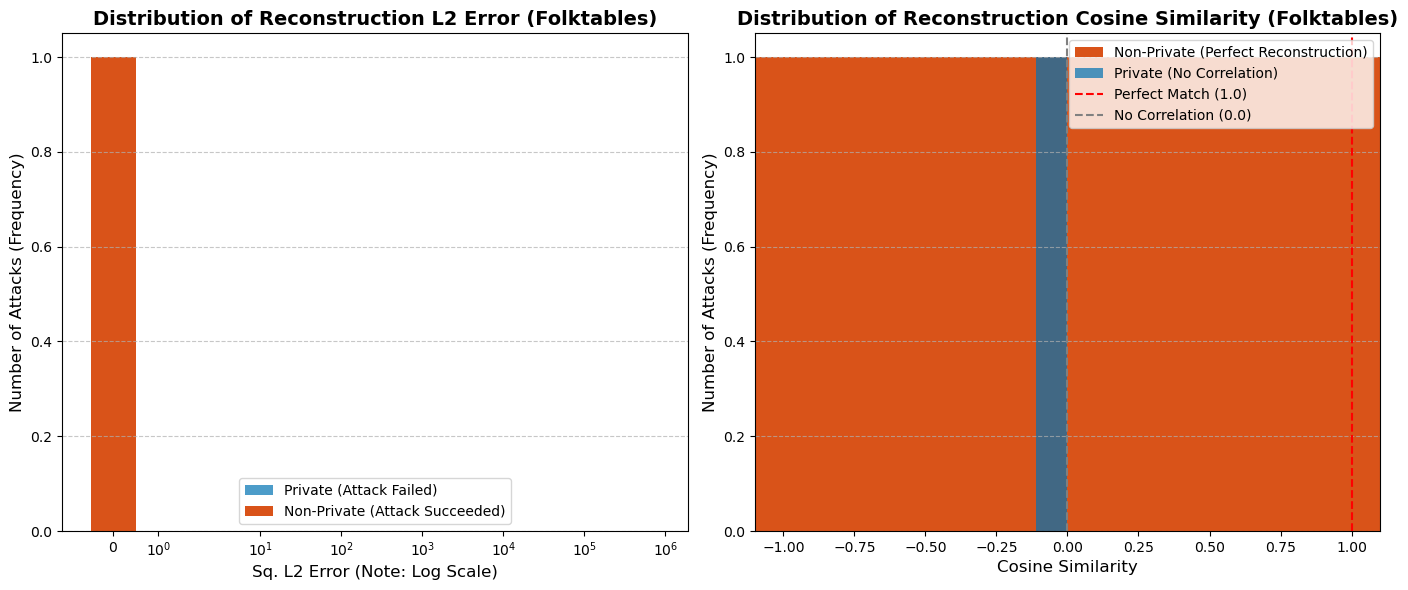

In [12]:
plt.figure(figsize=(14, 6))
colors = ['#D95319', '#0072B2'] # (Red/Orange, Blue)

# --- Plot 1: L2 Error Histogram --- 
plt.subplot(1, 2, 1)
if results['private']['errors']:
    plt.hist(results['private']['errors'], bins=30, alpha=0.7, color=colors[1], label='Private (Attack Failed)')
if results['non_private']['errors']:
    plt.hist(results['non_private']['errors'], bins=1, alpha=1.0, color=colors[0], label='Non-Private (Attack Succeeded)')

plt.title('Distribution of Reconstruction L2 Error (Folktables)', fontsize=14, fontweight='bold')
plt.xlabel('Sq. L2 Error (Note: Log Scale)', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xscale('symlog') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# --- Plot 2: Cosine Similarity Histogram --- 
plt.subplot(1, 2, 2)
if results['non_private']['cosine_sims']:
    plt.hist(results['non_private']['cosine_sims'], bins=1, range=(-1.1, 1.1), alpha=1.0, color=colors[0], label='Non-Private (Perfect Reconstruction)')
if results['private']['cosine_sims']:
    plt.hist(results['private']['cosine_sims'], bins=20, range=(-1.1, 1.1), alpha=0.7, color=colors[1], label='Private (No Correlation)')

plt.title('Distribution of Reconstruction Cosine Similarity (Folktables)', fontsize=14, fontweight='bold')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xlim(-1.1, 1.1)

# Add reference lines for clarity
plt.axvline(1.0, color='red', linestyle='--', label='Perfect Match (1.0)')
plt.axvline(0.0, color='grey', linestyle='--', label='No Correlation (0.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

## Step 6: Cleanup

Finally, we remove all the temporary config files, model center files (`.npy`), and results files (`.pkl`) created during the run.

In [13]:
print("\n--- 6. Cleaning up generated files... ---")
try:
    if 'config_non_private_file' in locals() and os.path.exists(config_non_private_file): 
        os.remove(config_non_private_file)
        print(f"Removed {config_non_private_file}")
    if 'config_private_file' in locals() and os.path.exists(config_private_file): 
        os.remove(config_private_file)
        print(f"Removed {config_private_file}")
    if os.path.exists('final_centers.npy'): 
        os.remove('final_centers.npy')
        print("Removed final_centers.npy")
        
    # Clean up utility results files
    if 'config_non_private_file' in locals():
        for cfg_file in [config_non_private_file, config_private_file]:
            try:
                ns = load_config_as_namespace(cfg_file) # Config file might be deleted, load from memory
                ptype = 'data_point_level' if ns.datapoint_privacy else 'client_level'
                rpath = make_results_path(ptype, ns.dataset)
                sfile = os.path.join(rpath, 'summary_results.pkl')
                if os.path.exists(sfile): 
                    os.remove(sfile)
                    print(f"Removed {sfile}")
            except Exception as e:
                print(f"Note: Could not clean up summary file for {cfg_file}. It may already be gone. {e}")
            
    print("Cleanup complete.")
except OSError as e: 
    print(f"Error during cleanup: {e}")


--- 6. Cleaning up generated files... ---
Removed configs/folktables_datapoint_non_private.yaml
Removed configs/folktables_datapoint_private.yaml
Note: Could not clean up summary file for configs/folktables_datapoint_non_private.yaml. It may already be gone. [Errno 2] No such file or directory: 'configs/folktables_datapoint_non_private.yaml'
Note: Could not clean up summary file for configs/folktables_datapoint_private.yaml. It may already be gone. [Errno 2] No such file or directory: 'configs/folktables_datapoint_private.yaml'
Cleanup complete.
